<a href="https://colab.research.google.com/github/macgyver121/DADS7202_hw2/blob/main/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-aa3052be-3021-f027-bcdd-47ce16ab08ef)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


## **** Mount + Import library ****

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import activations

## **** Import + Prepare Data ****

In [ ]:
### edit directory
###
###

data_directory = pathlib.Path('/content/drive/MyDrive/Garbage')
class_names = [item.name for item in data_directory.glob('*')][0:]
class_names.sort()
print(class_names)

['class1:Pim', 'class2:Karn', 'class3:Big', 'class4:PMac']


In [ ]:
### edit directory

class1_dir = '/content/drive/MyDrive/Garbage/class1:Pim'
class2_dir = '/content/drive/MyDrive/Garbage/class2:Karn'
class3_dir = '/content/drive/MyDrive/Garbage/class3:Big'
class4_dir = '/content/drive/MyDrive/Garbage/class4:PMac'
data_dir = '/content/drive/MyDrive/Garbage'

In [ ]:
class1_images = len(os.listdir(class1_dir))
class2_images = len(os.listdir(class2_dir))
class3_images = len(os.listdir(class3_dir))
class4_images = len(os.listdir(class4_dir))

print(f'Number of class1 images: {class1_images}')
print(f'Number of class2 images: {class2_images}')
print(f'Number of class3 images: {class3_images}')
print(f'Number of class4 images: {class4_images}')

Number of class1 images: 3
Number of class2 images: 5
Number of class3 images: 4
Number of class4 images: 5


In [ ]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator 
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.3)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 717 images belonging to 4 classes.
Found 305 images belonging to 4 classes.


In [ ]:
x_train, y_train = train_data.next()
len(x_train), len(y_train), x_train[0].shape

(700, 700, (224, 224, 3))

In [ ]:
x_test, y_test = test_data.next()
len(x_test), len(y_test), x_test[0].shape

(300, 300, (224, 224, 3))

## EDA

In [ ]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(629, 224, 224, 3) , min=0.0 , max=1.0
x_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(269, 224, 224, 3) , min=0.0 , max=1.0


In [ ]:
df_train = pd.DataFrame(y_train, columns = ['class'])
df_test = pd.DataFrame(y_test, columns = ['class'])

In [ ]:
df_train_count = pd.DataFrame(df_train.groupby(['class'])['class'].count())
df_train_count

,class
class,
0.0,148
1.0,187
2.0,140
3.0,154


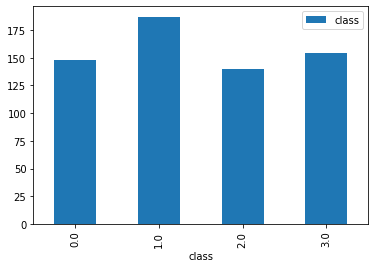

In [ ]:
df_train_count.plot.bar()

In [ ]:
df_test_count = pd.DataFrame(df_test.groupby(['class'])['class'].count())
df_test_count

,class
class,
0.0,63
1.0,80
2.0,60
3.0,66


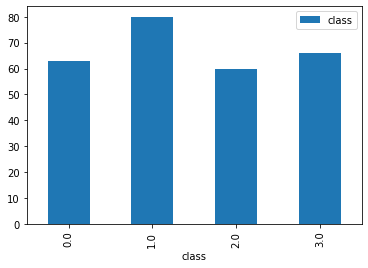

In [ ]:
df_test_count.plot.bar()

In [ ]:
for i in range(10) :
    print(y_train[i])

2.0
2.0
1.0
3.0
3.0
2.0
1.0
3.0
1.0
1.0


Each class size

In [ ]:
from PIL import Image

directories = {'Class_0': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class1/',
'Class_1': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class2/',
'Class_2': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class3/',
'Class_3': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class4/'}

def get_dims(file):
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

In [ ]:
import dask.bag as bag
from dask.diagnostics import ProgressBar

for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)

print(dims[0:10])

with ProgressBar():
  dims = dims.compute()
  dim_df = pd.DataFrame(dims, columns=['height', 'width'])
  sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
  sizes.plot.scatter(x='width', y='height');
  plt.title('Image Sizes (pixels) | {}'.format(n))

TypeError: ignored

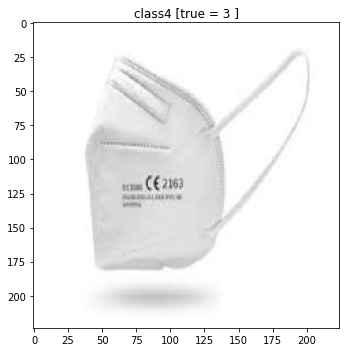

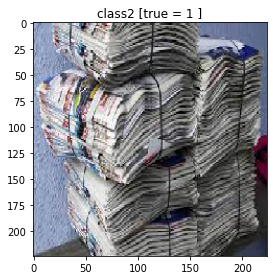

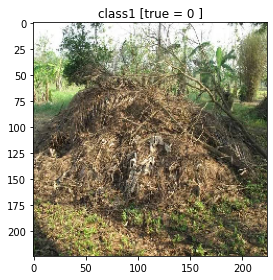

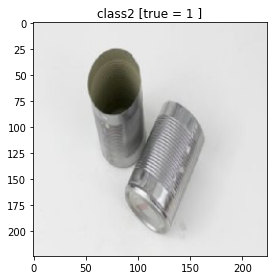

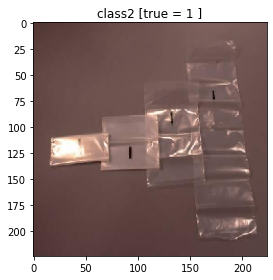

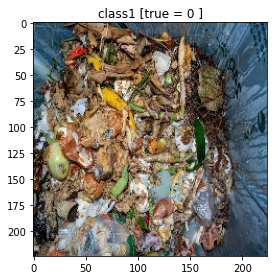

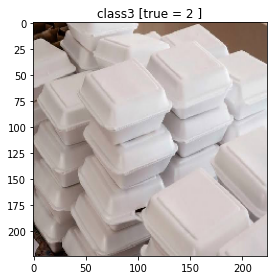

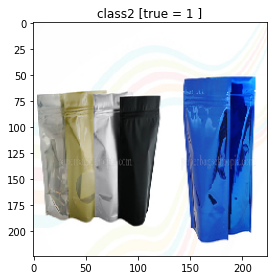

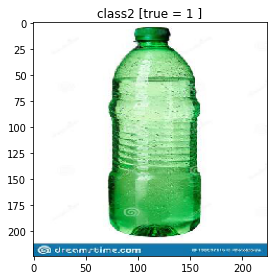

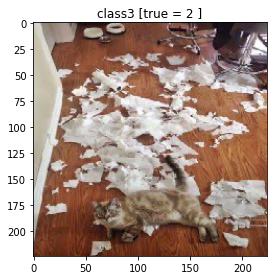

In [ ]:
# Visualize the first five images in x_train
plt.figure(figsize=(10,5))
for i in range(10,20):
    plt.title( f"{class_names[ int(y_train[i]) ]} [true = {int(y_train[i])} ]") 
    plt.imshow( x_train[i] )  
    plt.tight_layout()       
    plt.show()

# MobileNet

## Create the base model from the pre-trained convnets

In [ ]:
# Load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part
vgg_extractor = tf.keras.applications.mobilenet.MobileNet(weights = "imagenet", include_top=True)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# delete last layer
from keras.models import Model
vgg_extractor= Model(inputs=vgg_extractor.input, outputs=vgg_extractor.layers[-2].output)

In [ ]:
vgg_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## Feature Extractor

### Freeze the convolutional base

In [ ]:
vgg_extractor.trainable = False

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = conv1 , trainable = False
Layer 2: name = conv1_bn , trainable = False
Layer 3: name = conv1_relu , trainable = False
Layer 4: name = conv_dw_1 , trainable = False
Layer 5: name = conv_dw_1_bn , trainable = False
Layer 6: name = conv_dw_1_relu , trainable = False
Layer 7: name = conv_pw_1 , trainable = False
Layer 8: name = conv_pw_1_bn , trainable = False
Layer 9: name = conv_pw_1_relu , trainable = False
Layer 10: name = conv_pad_2 , trainable = False
Layer 11: name = conv_dw_2 , trainable = False
Layer 12: name = conv_dw_2_bn , trainable = False
Layer 13: name = conv_dw_2_relu , trainable = False
Layer 14: name = conv_pw_2 , trainable = False
Layer 15: name = conv_pw_2_bn , trainable = False
Layer 16: name = conv_pw_2_relu , trainable = False
Layer 17: name = conv_dw_3 , trainable = False
Layer 18: name = conv_dw_3_bn , trainable = False
Layer 19: name = conv_dw_3_relu , trainable = False
Layer 20: name = conv_pw_3 , traina

### Add a classification head

In [ ]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 

new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

Plot Model

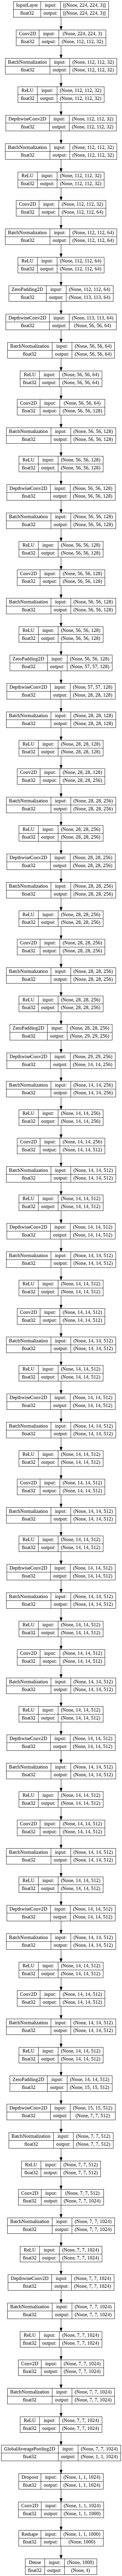

In [ ]:
tf.keras.utils.plot_model(model, to_file='vgg_original.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

### Preprocessing input

In [ ]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, rescale = 1/255., validation_split = 0.3)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 717 images belonging to 4 classes.
Found 305 images belonging to 4 classes.


In [ ]:
x_train, y_train = train_data.next()
x_test, y_test = test_data.next()

### Compile the model

In [ ]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

### Train the model

In [ ]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=30, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/30
49/49 [==============================] - ETA: 0s - loss: 1.4404 - acc: 0.3456
Epoch 1: val_acc improved from -inf to 0.34123, saving model to weights.hdf5
49/49 [==============================] - 12s 45ms/step - loss: 1.4404 - acc: 0.3456 - val_loss: 1.3511 - val_acc: 0.3412
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 1.3219 - acc: 0.3906
Epoch 2: val_acc improved from 0.34123 to 0.42654, saving model to weights.hdf5
49/49 [==============================] - 1s 24ms/step - loss: 1.3219 - acc: 0.3906 - val_loss: 1.2745 - val_acc: 0.4265
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 1.2175 - acc: 0.4581
Epoch 3: val_acc did not improve from 0.42654
49/49 [==============================] - 1s 20ms/step - loss: 1.2175 - acc: 0.4581 - val_loss: 1.2098 - val_acc: 0.4265
Epoch 4/30
49/49 [==============================] - ETA: 0s - loss: 1.1886 - acc: 0.5194
Epoch 4: val_acc improved from 0.42654 to 0.52133, saving model to weights.hdf5


### Learning curves

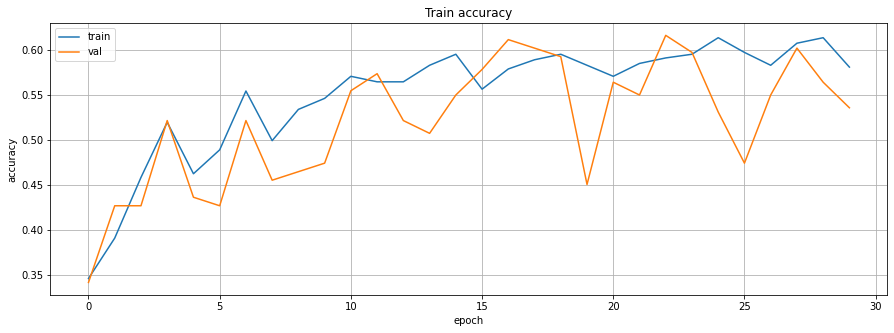

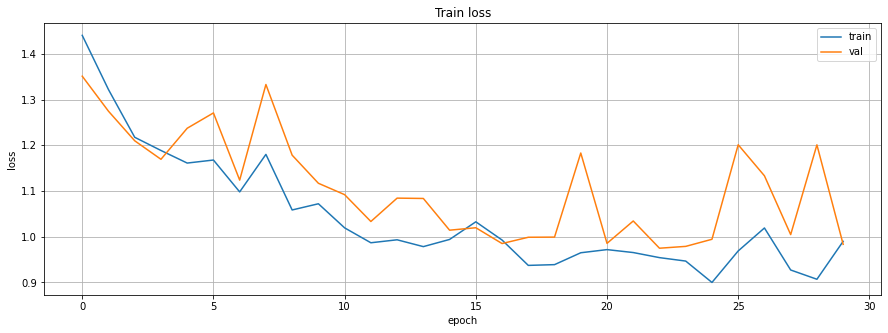

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Evaluate on test set

In [ ]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

10/10 [==============================] - 1s 66ms/step - loss: 1.6388 - acc: 0.3067
['loss', 'acc']: [1.6388484239578247, 0.30666667222976685]
Duration: 0:00:01.287000


### Evaluate on test set without seed

In [ ]:
# create model
vgg_extractor = tf.keras.applications.mobilenet.MobileNet(weights = "imagenet", include_top=True)
vgg_extractor= Model(inputs=vgg_extractor.input, outputs=vgg_extractor.layers[-2].output)
vgg_extractor.trainable = False

# add classifier
x = vgg_extractor.output
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)

#train model without seed
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)
history = model.fit( x_train , y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 1.5760 - acc: 0.3088
Epoch 1: val_acc improved from -inf to 0.42654, saving model to weights.hdf5
49/49 [==============================] - 3s 37ms/step - loss: 1.5760 - acc: 0.3088 - val_loss: 1.2764 - val_acc: 0.4265
Epoch 2/50
48/49 [============================>.] - ETA: 0s - loss: 1.2977 - acc: 0.4083
Epoch 2: val_acc improved from 0.42654 to 0.49763, saving model to weights.hdf5
49/49 [==============================] - 1s 26ms/step - loss: 1.2931 - acc: 0.4131 - val_loss: 1.2522 - val_acc: 0.4976
Epoch 3/50
48/49 [============================>.] - ETA: 0s - loss: 1.2343 - acc: 0.4479
Epoch 3: val_acc did not improve from 0.49763
49/49 [==============================] - 1s 23ms/step - loss: 1.2317 - acc: 0.4499 - val_loss: 1.1909 - val_acc: 0.4265
Epoch 4/50
46/49 [===========================>..] - ETA: 0s - loss: 1.1896 - acc: 0.4935
Epoch 4: val_acc improved from 0.49763 to 0.50711, saving model to weights.hdf5
4

## Fine tuning

### Create feature extractor

In [ ]:
img_w,img_h = 224,224
vgg_extractor = tf.keras.applications.mobilenet.MobileNet(weights = "imagenet", include_top=True, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Add a classification head

In [ ]:
x = vgg_extractor.layers[-5].output

# Add our custom layer(s) to the end of the existing model 
#x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                   

Model flow

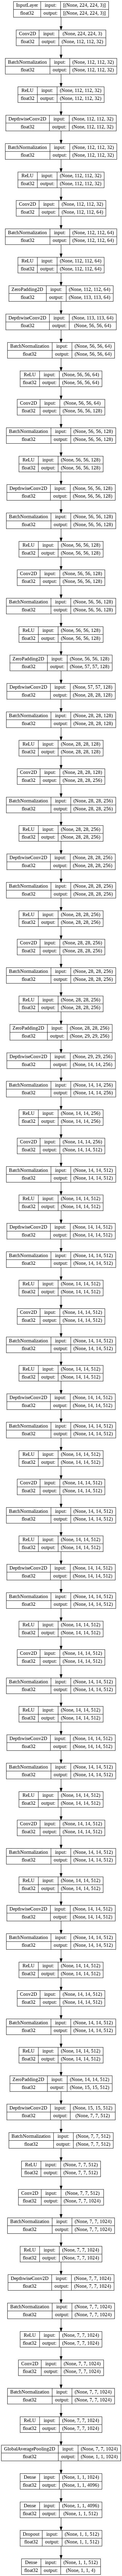

In [ ]:
tf.keras.utils.plot_model(model, to_file='vgg_original.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

### Compile the model

In [ ]:
alpha = 0.001
model.compile( loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate = alpha) , metrics=["acc"] )

### Train the model

In [ ]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=30, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/30
49/49 [==============================] - ETA: 0s - loss: 1.5664 - acc: 0.3026
Epoch 1: val_acc improved from -inf to 0.22846, saving model to weights.hdf5
49/49 [==============================] - 7s 97ms/step - loss: 1.5664 - acc: 0.3026 - val_loss: 6.8079 - val_acc: 0.2285
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 0.4161 - acc: 0.3186
Epoch 2: val_acc did not improve from 0.22846
49/49 [==============================] - 4s 73ms/step - loss: 0.4161 - acc: 0.3186 - val_loss: 4.2931 - val_acc: 0.2285
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 0.2318 - acc: 0.3305
Epoch 3: val_acc did not improve from 0.22846
49/49 [==============================] - 4s 74ms/step - loss: 0.2318 - acc: 0.3305 - val_loss: 6.2141 - val_acc: 0.2285
Epoch 4/30
49/49 [==============================] - ETA: 0s - loss: 0.1122 - acc: 0.3319
Epoch 4: val_acc improved from 0.22846 to 0.23417, saving model to weights.hdf5
49/49 [============================

### Learning curves

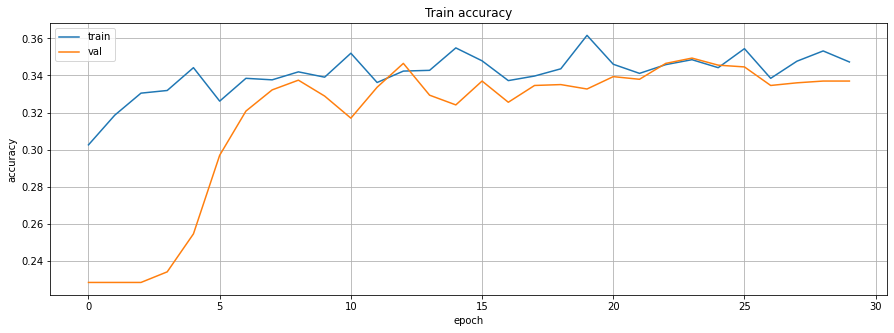

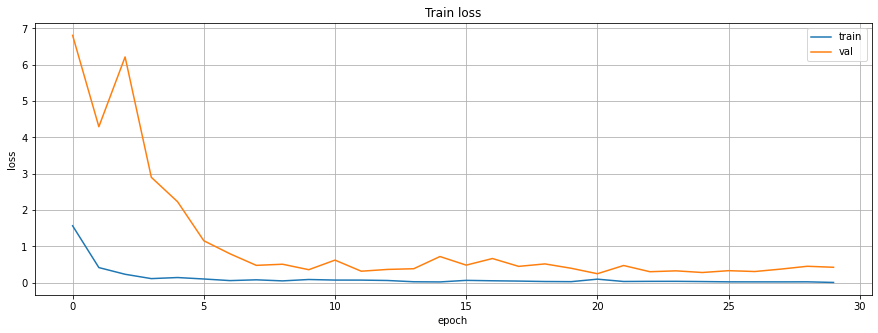

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Evaluate on test set

In [ ]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

10/10 [==============================] - 0s 43ms/step - loss: 2.5080 - acc: 0.3147
['loss', 'acc']: [2.5079751014709473, 0.3147435784339905]
Duration: 0:00:00.794419


### Evaluate on test set without seed

In [ ]:
# create model
img_w,img_h = 224,224 
vgg_extractor = tf.keras.applications.mobilenet.MobileNet(weights = "imagenet", include_top=True, input_shape = (img_w, img_h, 3))

x = vgg_extractor.layers[-5].output

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)

#train model without seed
alpha = 0.001
model.compile( loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate = alpha) , metrics=["acc"] )

start_time = datetime.now()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 1.8430 - acc: 0.5787
Epoch 1: val_acc improved from -inf to 0.22749, saving model to weights.hdf5
49/49 [==============================] - 7s 105ms/step - loss: 1.8430 - acc: 0.5787 - val_loss: 3.7152 - val_acc: 0.2275
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.4995 - acc: 0.8384
Epoch 2: val_acc did not improve from 0.22749
49/49 [==============================] - 4s 73ms/step - loss: 0.4995 - acc: 0.8384 - val_loss: 3.7590 - val_acc: 0.2275
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.2509 - acc: 0.9223
Epoch 3: val_acc did not improve from 0.22749
49/49 [==============================] - 4s 74ms/step - loss: 0.2509 - acc: 0.9223 - val_loss: 4.7791 - val_acc: 0.2275
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.1827 - acc: 0.9387
Epoch 4: val_acc improved from 0.22749 to 0.25592, saving model to weights.hdf5
49/49 [===========================

## Inference + Prediction

In [ ]:
y_pred = model.predict(x_test)
print(y_pred.shape)

9/9 [==============================] - 1s 156ms/step
(269, 4)


In [ ]:
lst = []
for i in y_pred :
    lst.append(np.argmax(i))

type(np.array(lst))

numpy.ndarray

In [ ]:
y_test[0:10]

array([1., 0., 1., 2., 1., 1., 2., 2., 3., 0.], dtype=float32)

In [ ]:
lst[0:10]

[3, 1, 1, 2, 1, 1, 1, 3, 3, 2]

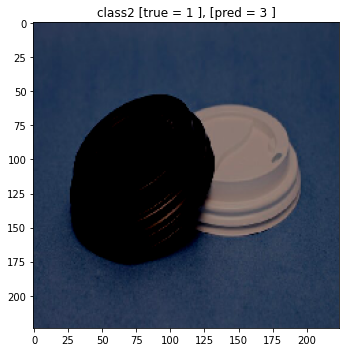

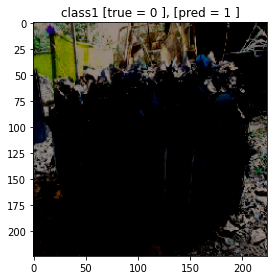

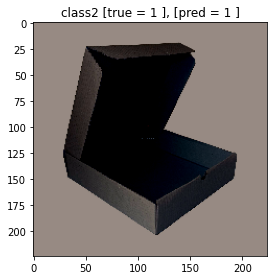

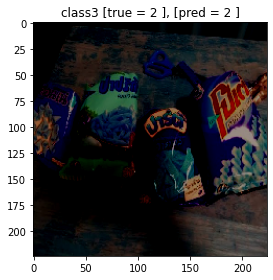

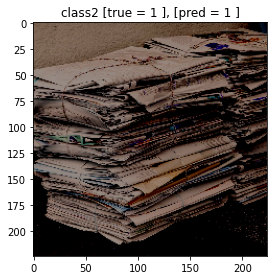

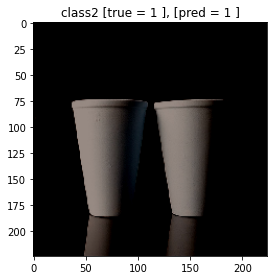

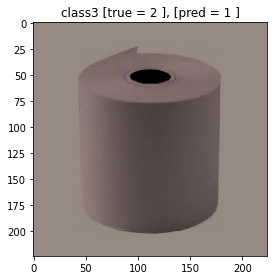

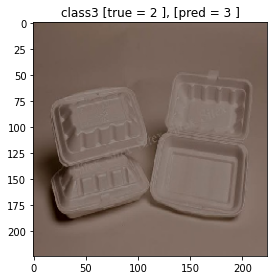

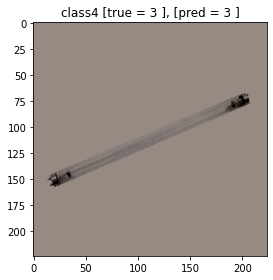

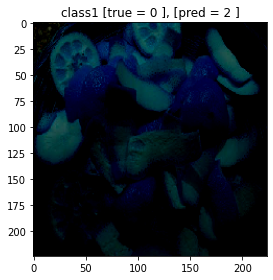

In [ ]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in range(0,10):
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()

## Check error

In [ ]:
y_test = y_test.astype(int)
df = pd.DataFrame(list(zip(y_test, lst)), columns = ['y_test', 'y_pred'])

In [ ]:
print(df.head())

   y_test  y_pred
0       1       3
1       0       1
2       1       1
3       2       2
4       1       1


In [ ]:
index_list = df[df['y_test'] != df['y_pred']].index

In [ ]:
index_list

Int64Index([  0,   1,   6,   7,   9,  10,  11,  13,  22,  25,  26,  27,  29,
             33,  36,  38,  40,  44,  45,  46,  52,  53,  54,  56,  60,  62,
             78,  87,  88,  98,  99, 100, 112, 117, 119, 127, 130, 131, 132,
            133, 136, 151, 160, 162, 165, 166, 170, 171, 177, 179, 180, 184,
            187, 192, 194, 195, 199, 205, 207, 210, 211, 215, 221, 224, 226,
            227, 230, 233, 235, 251, 253, 256, 258, 260, 265, 267, 268],
           dtype='int64')

In [ ]:
len(index_list)

77

In [ ]:
df.iloc[index_list]

,y_test,y_pred
0,1,3
1,0,1
6,2,1
7,2,3
9,0,2
...,...,...
258,2,3
260,1,3
265,3,2
267,1,2


In [ ]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in index_list:
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()